#### Bayesian Logit Normal Inference
We assume that the logit transformation of our response, 
$$z_i = \log\left(\frac{y_i}{1-y_i}\right)$$
is modeled as
$$z_i \sim \mathcal{N}(X_i\beta,\,\sigma^2)$$
This means that the likelihood is
$$L(\beta,\sigma^2\mid z) \propto (2\pi\sigma^2)^{-n/2}\exp\!\Bigl\{-\frac{1}{2\sigma^2}(z-X\beta)^\top(z-X\beta)\Bigr\}$$
Using Jeffrey's prior, we have:
$$\pi(\beta,\sigma^2) \propto \frac{1}{\sigma^{p+2}}$$
Which leads (after some algebra) to closed form conditionals:
- Conditional for $\beta$ given $\sigma^2$:
$$\beta\mid\sigma^2,z \sim \mathcal{N}\Bigl(\hat{\beta},\,\sigma^2 (X^\top X)^{-1}\Bigr)$$
with $\hat{\beta} = (X^\top X)^{-1}X^\top z$.

- Conditional for $\sigma^2$ given $\beta$:
$$\sigma^2\mid\beta,z \sim \text{Inverse-Gamma}\Bigl(\frac{n}{2},\,\frac{\text{SSE}}{2}\Bigr)$$
where $\text{SSE} = (z-X\beta)^\top(z-X\beta)$

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.special import logit
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import invgamma, multivariate_normal
import matplotlib.pyplot as plt
df = pd.read_csv('/Users/izzycoddington/Documents/Github/Bayesian-Logit-Normal-Reg/inputs/justice_score.csv', encoding='ISO-8859-1')
df


,score_JG,country_name_ltn,nuts_id,gend,edu,emp,age,urban,ethni_groups
0,0.351852,Austria,AT1,2,3.0,1,50,1,0.0
1,0.055556,Austria,AT1,2,6.0,1,49,1,0.0
2,0.500000,Austria,AT1,1,3.0,6,70,2,1.0
3,0.944444,Austria,AT1,2,5.0,7,39,1,1.0
4,0.500000,Austria,AT1,1,7.0,7,53,1,0.0
...,...,...,...,...,...,...,...,...,...
27703,0.055556,Sweden,SE3,2,7.0,1,31,1,0.0
27704,0.944444,Sweden,SE3,2,5.0,1,28,1,0.0
27705,0.055556,Sweden,SE3,1,4.0,3,26,1,0.0
27706,0.500000,Sweden,SE3,1,4.0,1,55,2,0.0


In [3]:
df.columns

Index(['score_JG', 'country_name_ltn', 'nuts_id', 'gend', 'edu', 'emp', 'age',
       'urban', 'ethni_groups'],
      dtype='object')

In [8]:
df = df.loc[
    (df['gend'] != 98) & (df['gend'] != 99) & (df['gend'] != 4) & (df['gend'] != 3) &
    (df['edu']  != 98) & (df['edu']  != 99) &
    (df['emp']  != 98) & (df['emp']  != 99) &
    (df['age']  != 98) & (df['age']  != 99) &
    (df['urban']!= 98) & (df['urban']!= 99)
 ]

df = df.dropna(subset = ['country_name_ltn', 'nuts_id', 'gend', 'edu', 'emp', 'age',
       'urban', 'ethni_groups'])

<Axes: ylabel='Density'>

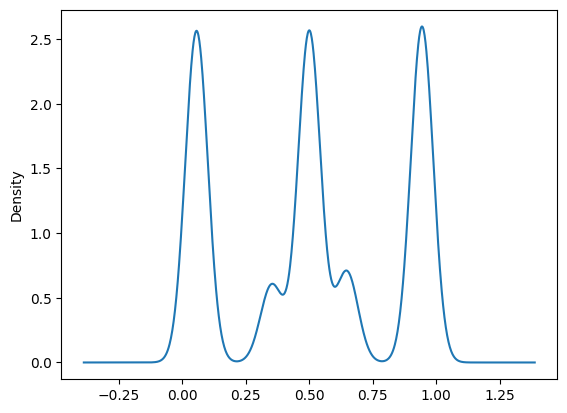

In [10]:
df['score_JG'].plot(kind= 'kde')

<Axes: ylabel='Density'>

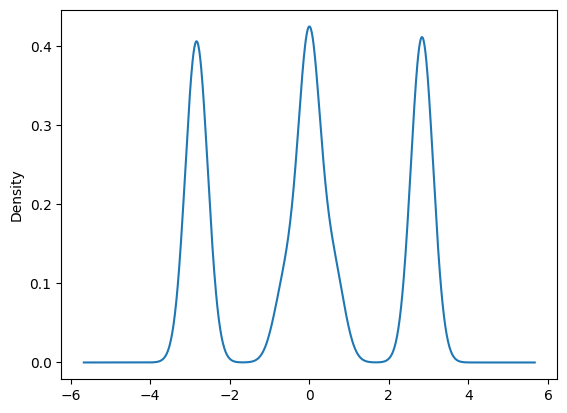

In [11]:
log_score = logit(df['score_JG'])
log_score.plot(kind='kde')

In [12]:
df['gend'] = df['gend'].apply(lambda x: 0 if x == 2 else 1)
df['urban'] = df['urban'].apply(lambda x: 0 if x == 2 else 1)

df

,score_JG,country_name_ltn,nuts_id,gend,edu,emp,age,urban,ethni_groups
0,0.351852,Austria,AT1,0,3.0,1,50,1,0.0
1,0.055556,Austria,AT1,0,6.0,1,49,1,0.0
2,0.500000,Austria,AT1,1,3.0,6,70,0,1.0
3,0.944444,Austria,AT1,0,5.0,7,39,1,1.0
4,0.500000,Austria,AT1,1,7.0,7,53,1,0.0
...,...,...,...,...,...,...,...,...,...
27703,0.055556,Sweden,SE3,0,7.0,1,31,1,0.0
27704,0.944444,Sweden,SE3,0,5.0,1,28,1,0.0
27705,0.055556,Sweden,SE3,1,4.0,3,26,1,0.0
27706,0.500000,Sweden,SE3,1,4.0,1,55,0,0.0


In [13]:
# Maybe we should explore scaling ALL of these values, Idk why but just seems like it could maybe help... 
df_grouped = df.groupby(['country_name_ltn','nuts_id']).mean().reset_index()
df_grouped

,country_name_ltn,nuts_id,score_JG,gend,edu,emp,age,urban,ethni_groups
0,Austria,AT1,0.506216,0.484848,5.013986,2.904429,45.965035,0.715618,0.610723
1,Austria,AT2,0.503779,0.428571,4.997449,2.918367,46.872449,0.599490,0.573980
2,Austria,AT3,0.516629,0.431122,4.961735,2.711735,45.418367,0.635204,0.517857
3,Belgium,BE1,0.538249,0.487273,4.996364,2.909091,42.250909,1.000000,0.465455
4,Belgium,BE2,0.520412,0.466667,4.404444,3.368889,48.022222,0.928889,0.653333
...,...,...,...,...,...,...,...,...,...
102,Spain,ES6,0.494926,0.486301,4.917808,2.760274,45.044521,0.897260,0.000000
103,Spain,ES7,0.544269,0.434911,5.032544,2.618343,43.775148,0.934911,0.000000
104,Sweden,SE1,0.503688,0.481328,4.887967,2.576763,43.124481,0.879668,0.000000
105,Sweden,SE2,0.485111,0.452261,4.959799,2.834171,47.346734,0.683417,0.000000


<Axes: ylabel='Density'>

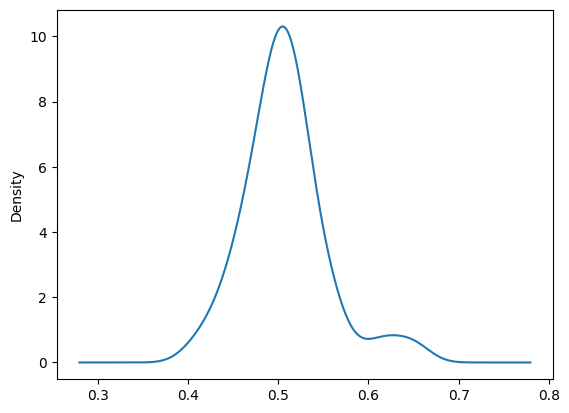

In [14]:
df_grouped.score_JG.plot(kind = 'kde')

<Axes: ylabel='Density'>

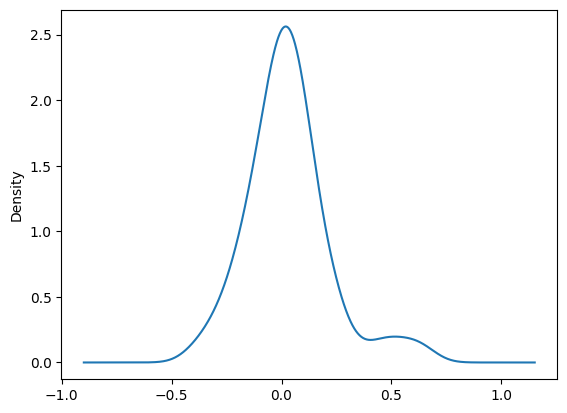

In [15]:
X = logit(df_grouped.score_JG)
X.plot(kind = 'kde')

In [16]:
Y = df_grouped[["gend","edu","emp","age","urban","ethni_groups"]]

<Axes: >

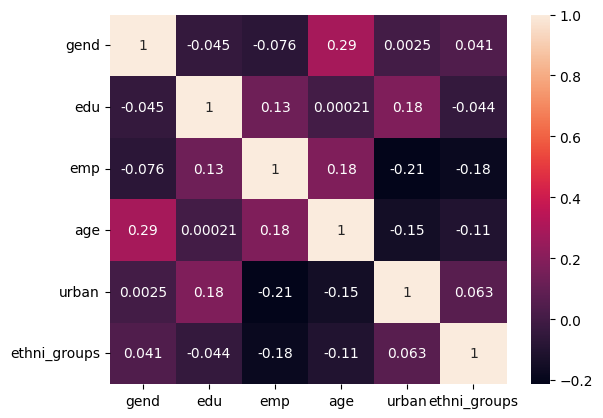

In [17]:
sns.heatmap(Y.corr(),annot=True)

In [18]:
# This is flipped because my X and Y were flipped further up 
Y_train,Y_test,X_train, X_test,  = train_test_split(X,Y,test_size=0.5)

In [19]:
p = X_train.shape[1]
n = X_train.shape[0]
beta_0 = np.zeros(p)  
V_0 = np.eye(p) * 10
a_0, b_0 = 2, 2  

In [20]:
V_n = np.linalg.inv(X_train.T @ X_train + np.linalg.inv(V_0))
beta_n = V_n @ (X_train.T @ Y_train + np.linalg.inv(V_0) @ beta_0)
a_n = a_0 + n / 2
# b_n = b_0 + 0.5 * ((Y_train - X_train @ beta_n).T @ (Y_train - X_train @ beta_n))
b_n = b_0 + 0.5 * ((Y_train - X_train @ beta_n).T @ (Y_train - X_train @ beta_n)) + 0.5 * np.trace(X_train.T @ X_train @ V_n)


In [21]:
# sigma2_sample = invgamma.rvs(a_n, scale=b_n, size=1)
# sigma2_sample = invgamma.rvs(a_n, scale=b_n / a_n, size=1)  
sigma2_sample = invgamma.rvs(a_n, scale=b_n / a_n, size=1) *2 # multiplied by 2 to Increase variance
beta_sample = multivariate_normal.rvs(beta_n, V_n)
mu_pred = X_test @ beta_sample
logit_samples = np.random.normal(mu_pred, np.sqrt(sigma2_sample))  # decided to sample in logit space
y_pred = 1 / (1 + np.exp(-logit_samples))  # Then transfor to probability space
Y_test = (Y_test - np.min(Y_test)) / (np.max(Y_test) - np.min(Y_test))
# y_pred = 1 / (1 + np.exp(-np.random.normal(mu_pred, np.sqrt(sigma2_sample))))
y_pred

array([0.54391681, 0.62202038, 0.3601798 , 0.65466376, 0.34929909,
       0.43697642, 0.59656935, 0.35554336, 0.58675805, 0.6793505 ,
       0.46683713, 0.54774232, 0.42610147, 0.48818256, 0.60112089,
       0.64348267, 0.27342117, 0.50219166, 0.51226802, 0.41398278,
       0.5098185 , 0.46165081, 0.68886027, 0.43228966, 0.41561723,
       0.67997464, 0.39032238, 0.60454776, 0.63387617, 0.51953875,
       0.53332161, 0.48455623, 0.6751634 , 0.52536169, 0.49296945,
       0.39973496, 0.50774879, 0.41398496, 0.61580799, 0.49446896,
       0.62861525, 0.5358768 , 0.45798423, 0.56936816, 0.56015043,
       0.68846798, 0.51446723, 0.66262067, 0.64219765, 0.73168012,
       0.43655422, 0.53461817, 0.66650775, 0.58077182])

In [22]:
def convert_back_vector(y):
    y = np.clip(y, 1e-9, 1 - 1e-9)  
    mu = np.log(y / (1 - y))
    return 1 / (1 + np.exp(-mu)) 
# DO WE CONVERT BOTH BACK? WHY at this point in time?
y_pred= convert_back_vector(y_pred)
Y_test = convert_back_vector(Y_test)
print(f"y_pred:{y_pred}")
print(f"Y_test:{Y_test}")
# I think we are having problems with the amount of variance that we ar trying to capture
print(f"Variance of Y_test: {np.var(Y_test):.4f}")
print(f"Variance of y_pred: {np.var(y_pred):.4f}")


y_pred:[0.54391681 0.62202038 0.3601798  0.65466376 0.34929909 0.43697642
 0.59656935 0.35554336 0.58675805 0.6793505  0.46683713 0.54774232
 0.42610147 0.48818256 0.60112089 0.64348267 0.27342117 0.50219166
 0.51226802 0.41398278 0.5098185  0.46165081 0.68886027 0.43228966
 0.41561723 0.67997464 0.39032238 0.60454776 0.63387617 0.51953875
 0.53332161 0.48455623 0.6751634  0.52536169 0.49296945 0.39973496
 0.50774879 0.41398496 0.61580799 0.49446896 0.62861525 0.5358768
 0.45798423 0.56936816 0.56015043 0.68846798 0.51446723 0.66262067
 0.64219765 0.73168012 0.43655422 0.53461817 0.66650775 0.58077182]
Y_test:71     1.727026e-01
34     4.610996e-01
69     3.062423e-01
31     3.818215e-01
27     5.487525e-01
67     2.646433e-01
18     6.311293e-01
98     4.126787e-01
4      4.564836e-01
36     6.213459e-01
45     4.067368e-01
62     3.855915e-01
86     5.927009e-01
101    3.809837e-01
57     3.343967e-01
58     8.833642e-01
56     9.914189e-01
13     8.561945e-02
53     2.678410e-01
75 

In [1407]:
def MSE_RMSE_MAE_R2(y_test, y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    ss_total = np.sum((y_test - np.mean(y_test)) ** 2)  
    ss_residual = np.sum((y_test - y_pred) ** 2)  
    r2 = 1 - (ss_residual / ss_total) if ss_total != 0 else float("nan") 
    MSE = np.mean((y_test - y_pred) ** 2)
    RMSE = np.sqrt(MSE)
    MAE = np.mean(np.abs(y_test - y_pred))
    return MSE, RMSE, MAE, r2
MSE, RMSE, MAE, R2 = MSE_RMSE_MAE_R2(Y_test, y_pred)

print(f"Model Performance Metrics:")
print("--------------------------------")
print(f"Mean Squared Error (MSE)  : {MSE:.4f}")
print(f"Root Mean Squared Error (RMSE) : {RMSE:.4f}")
print(f"Mean Absolute Error (MAE) : {MAE:.4f}")
print(f"R² Score : {R2:.4f}")


Model Performance Metrics:
--------------------------------
Mean Squared Error (MSE)  : 0.0721
Root Mean Squared Error (RMSE) : 0.2686
Mean Absolute Error (MAE) : 0.2200
R² Score : -1.3649


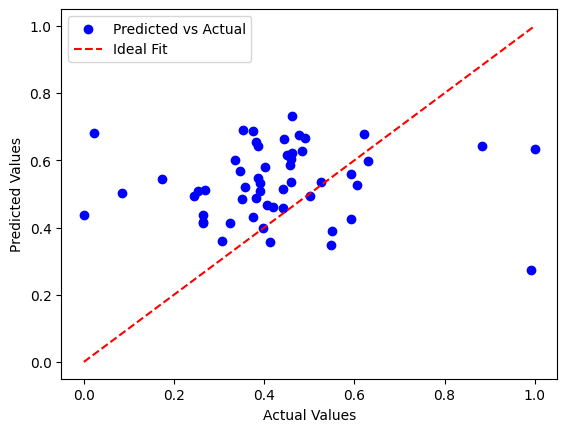

In [23]:
plt.scatter(Y_test, y_pred, color="blue", label="Predicted vs Actual")
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color="red", linestyle="dashed", label="Ideal Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()


<Axes: ylabel='Density'>

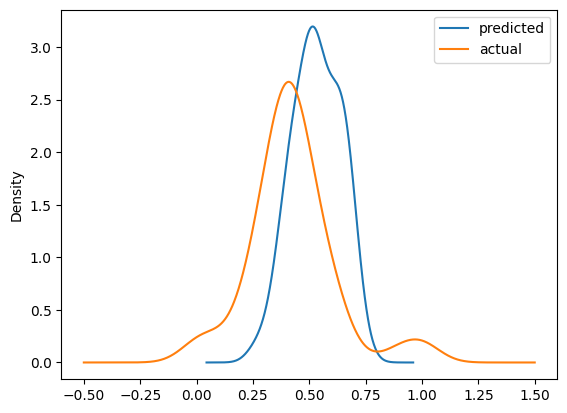

In [24]:
Y_test = np.array(Y_test)
comparisons = pd.DataFrame({"predicted": y_pred, "actual": Y_test})
comparisons
# comparisons.plot()
comparisons.plot(kind='kde')

Text(0.5, 1.0, 'Distribution of Predictions vs. Actuals')

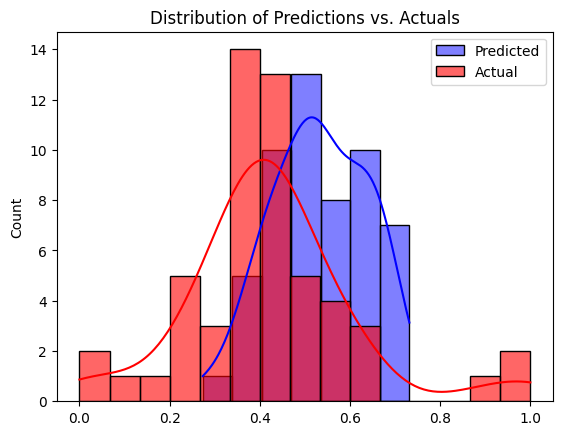

In [25]:
sns.histplot(y_pred, kde=True, color="blue", label="Predicted")
sns.histplot(Y_test, kde=True, color="red", label="Actual", alpha=0.6)
plt.legend()
plt.title("Distribution of Predictions vs. Actuals")

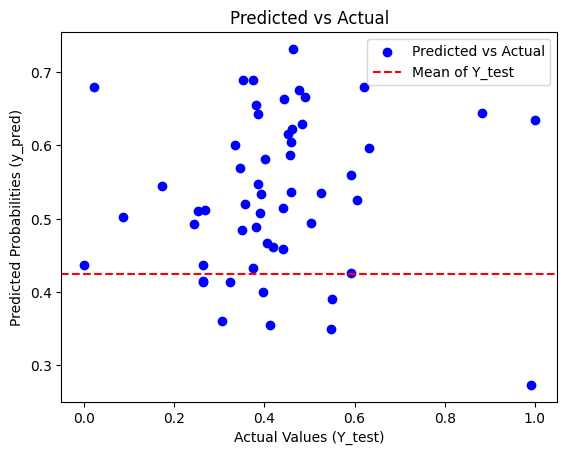

In [26]:
plt.scatter(Y_test, y_pred, color="blue", label="Predicted vs Actual")
plt.xlabel("Actual Values (Y_test)")
plt.ylabel("Predicted Probabilities (y_pred)")
plt.axhline(y=np.mean(Y_test), color="red", linestyle="dashed", label="Mean of Y_test")
plt.legend()
plt.title("Predicted vs Actual")
plt.show()
